In [24]:
%matplotlib inline 

# Basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Keras
import keras
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, Lambda, UpSampling2D

# Others
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Load Dataset
df=pd.read_msgpack('MREdata_072118.msg')

In [3]:
# Prepare Data
Ur = np.stack(df.Ur.values,axis=3).transpose(3,0,1,2)
Ui = np.stack(df.Ui.values,axis=3).transpose(3,0,1,2)
x_data = np.sqrt(Ui**2+Ur**2)

y_data = np.stack(df.RS.values,axis=2).transpose(2,0,1)
# y_data = y_data.reshape(612,-1)
y_data = y_data/10000.

print 'X size:', x_data.shape
print 'Y size:', y_data.shape

X size: (612, 64, 64, 3)
Y size: (612, 64, 64)


In [4]:
# Split to Train & Valid
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size=0.3)

print 'Training examples:   ', len(x_train)
print 'Validation examples: ', len(x_valid)
print 'Testing examples:    ', len(x_test)

Training examples:    299
Validation examples:  129
Testing examples:     184


### Building Neural Network

In [5]:
# Parameters
xshp   = x_train.shape[1:]
nbatch = 16
nepoch = 100

# Architecture
L1 = 64
L2 = 50
L3 = 32
L4 = 32

In [6]:
# Build Neural Model

# Encoding
x  = Input(shape=xshp,name='Input')
h  = Conv2D(L1,kernel_size=(5,5),strides=(2,2),activation='relu',padding='same',name='E1')(x)
h  = Conv2D(L2,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E2')(h)
h  = Conv2D(L3,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E3')(h)
e  = Conv2D(L4,kernel_size=(2,2),strides=(1,1),activation='relu',padding='same',name='E4')(h)

# Decoding
h  = Conv2D(L4,kernel_size=(2,2),activation='relu',padding='same',name='D1')(e)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(L3,kernel_size=(3,3),activation='relu',padding='same',name='D2')(h)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(L2,kernel_size=(3,3),activation='relu',padding='same',name='D3')(h)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(1,kernel_size=(5,5),activation='relu',padding='same',name='D4')(h)
y  = Lambda(lambda xx: K.squeeze(xx,3),name='Output')(h)

# Build Model
model = Model(inputs=x,outputs=y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
E1 (Conv2D)                  (None, 32, 32, 64)        4864      
_________________________________________________________________
E2 (Conv2D)                  (None, 16, 16, 50)        28850     
_________________________________________________________________
E3 (Conv2D)                  (None, 8, 8, 32)          14432     
_________________________________________________________________
E4 (Conv2D)                  (None, 8, 8, 32)          4128      
_________________________________________________________________
D1 (Conv2D)                  (None, 8, 8, 32)          4128      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 32)        0         
__________

In [7]:
# Compiling Model
model.compile(loss='mean_squared_error',optimizer='adam')

In [61]:
# Train Model
log = model.fit(x_train,y_train,
          epochs=nepoch,
          batch_size=nbatch,
          validation_data=(x_valid,y_valid))

Train on 299 samples, validate on 129 samples
Epoch 1/100
299/299 [==============================] - 11s 37ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 2/100
299/299 [==============================] - 10s 33ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 3/100
299/299 [==============================] - 10s 33ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 4/100
299/299 [==============================] - 10s 33ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 5/100
299/299 [==============================] - 10s 34ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 6/100
299/299 [==============================] - 12s 42ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 7/100
299/299 [==============================] - 10s 33ms/step - loss: 0.0025 - val_loss: 

## Model Evaluation

In [9]:
# Generate Predictions
y_pred = model.predict(x_test)

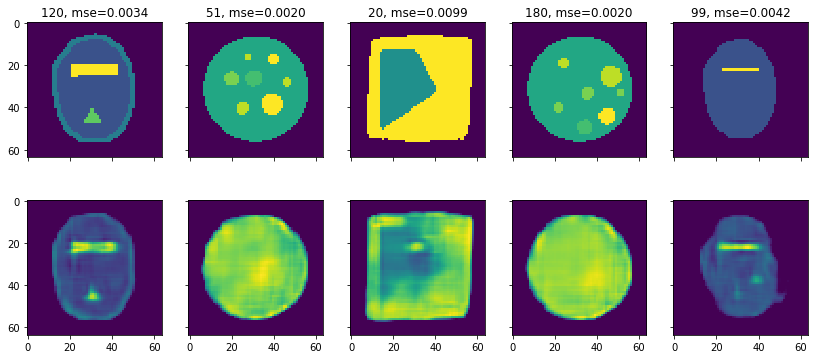

In [60]:
# Visualize Examples
K   = 5
row = 2
col = K

sidx = random.sample(range(len(y_pred)),K)

fig,axs = plt.subplots(row,col,sharex='col',sharey='row',figsize=(14,6))
for i,k in enumerate(sidx):
    axs[0,i%col].imshow(y_test[k])
    axs[1,i%col].imshow(y_pred[k])
    
    mse = mean_squared_error(y_pred[k],y_test[k])
    header = '{0}, mse={1:.04f}'.format(k,mse)
    axs[0,i%col].set_title(header)


## Custom Laplacian Loss Function 

In [ ]:
# Custom Loss Functions